In [1]:
# Re-creation of: https://youtu.be/68ABAU_V8qI?t=1897
# Data source:    https://www.kaggle.com/lsind18/weight-vs-age-of-chicks-on-different-diets

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS
from torch import zeros, ones

plt.style.use("ggplot")

In [3]:
df = pd.read_csv("ChickWeight.csv", index_col=0)

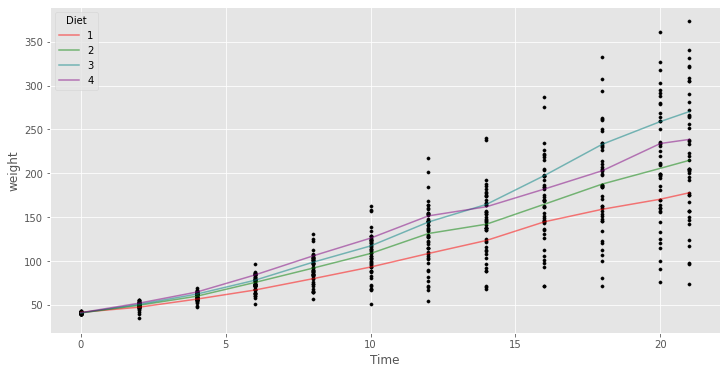

In [4]:
DIET_COLOURS = {
    1: "red", 2: "green", 3: "teal", 4: "purple"
}
plt.figure(figsize=(12, 6))
plt.scatter(df["Time"], df["weight"], c="black", s=10)
for diet, group in df.groupby("Diet"):
    resampled = group.groupby("Time").mean().reset_index()
    plt.plot(
        resampled["Time"], 
        resampled["weight"],
        label=diet, c=DIET_COLOURS[diet], alpha=0.5
    )

plt.ylabel("weight")
plt.xlabel("Time")
_ = plt.legend(title="Diet")

In [5]:
def model(time, diet):
    alpha_1 = pyro.sample('alpha_1', dist.Uniform(zeros(4), 10 * ones(4)))
    alpha_0 = pyro.sample("alpha_0", dist.Uniform(zeros(1), 10 * ones(1)))
    sigma = alpha_0 + alpha_1[diet] * time
    
    beta_1 = pyro.sample("beta_1", dist.Normal(zeros(4), 2 * ones(4)))
    beta_0 = pyro.sample("beta_0", dist.Normal(zeros(1), 2 * ones(1)))
    mu = beta_0 + beta_1[diet] * time

    pyro.sample('weight', dist.Normal(mu, sigma))

    
def conditioned_model(model, time, diet, weight):
    return poutine.condition(model, data={"weight": weight})(time, diet)

In [6]:
from torch import tensor as t

time, diet, weight = t(df["Time"].values), t(df["Diet"].values - 1), t(df["weight"].values)


nuts_kernel = NUTS(conditioned_model)
mcmc = MCMC(
    nuts_kernel,
    warmup_steps=100,
    num_samples=100,
    num_chains=1,
)
mcmc.run(model, time, diet, weight)

Sample: 100%|██████████████████████████████████████████| 200/200 [00:24,  8.26it/s, step size=2.38e-02, acc. prob=0.958]                                 


In [7]:
params = {}
for key, samples in mcmc.get_samples().items():
    if samples.shape[1] > 1:
        for i in range(samples.shape[1]):
            params[f"{key}[{i + 1}]"] = np.array(samples[:, i])
    else:
        params[key] = np.array(samples.flatten())

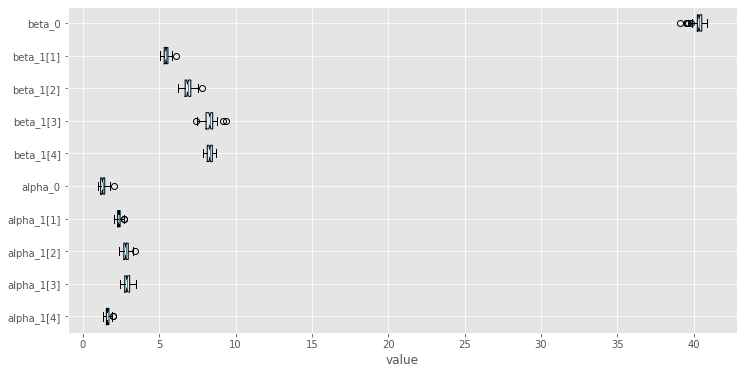

In [8]:
param_order = [
    "beta_0",
    "beta_1[1]",
    "beta_1[2]",
    "beta_1[3]",
    "beta_1[4]",
    "alpha_0",
    "alpha_1[1]",
    "alpha_1[2]",
    "alpha_1[3]",
    "alpha_1[4]",
][::-1]

plt.figure(figsize=(12, 6))
plt.boxplot(
    [np.array(params[k]) for k in param_order],
    param_order,
    vert=False,
)
plt.xlabel("value")

_ = plt.yticks(
    list(range(1, len(param_order) + 1)), 
    labels=param_order
)

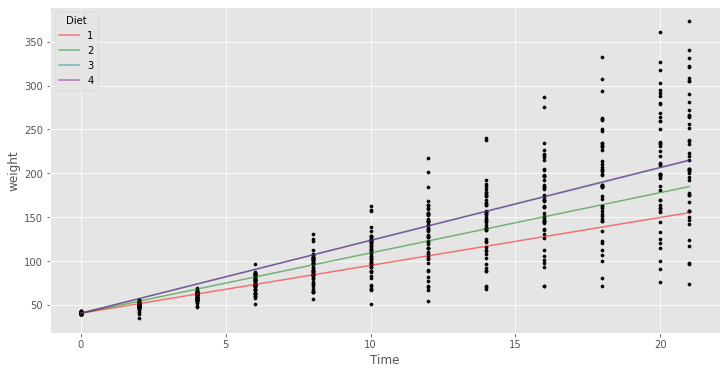

In [9]:
def forward(diet, time):
    mu = params["beta_0"] + params[f"beta_1[{diet}]"] * time
    return mu.mean()


plt.figure(figsize=(12, 6))
plt.scatter(df["Time"], df["weight"], c="black", s=10)
for diet in range(1, 5):
    plt.plot(
        list(range(22)),
        [forward(diet, i) for i in range(22)],
        label=diet, c=DIET_COLOURS[diet], alpha=0.5
    )
plt.ylabel("weight")
plt.xlabel("Time")
_ = plt.legend(title="Diet")